In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolve

In [2]:
# Importing packages 

import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf
import plotly.express as px

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.utils.multiclass import unique_labels
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B1, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

#Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm

2024-11-13 21:30:10.891217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731533410.923240      24 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731533410.932125      24 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.18.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Downloading files

# Four categories 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
    
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [5]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


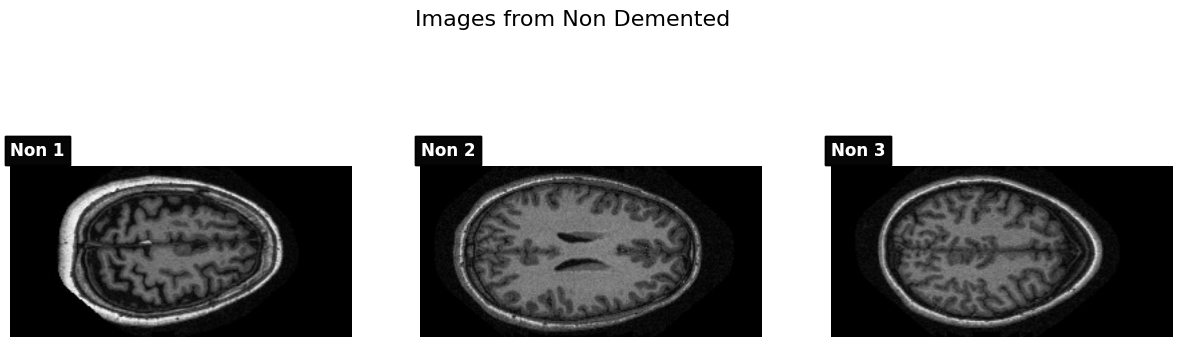

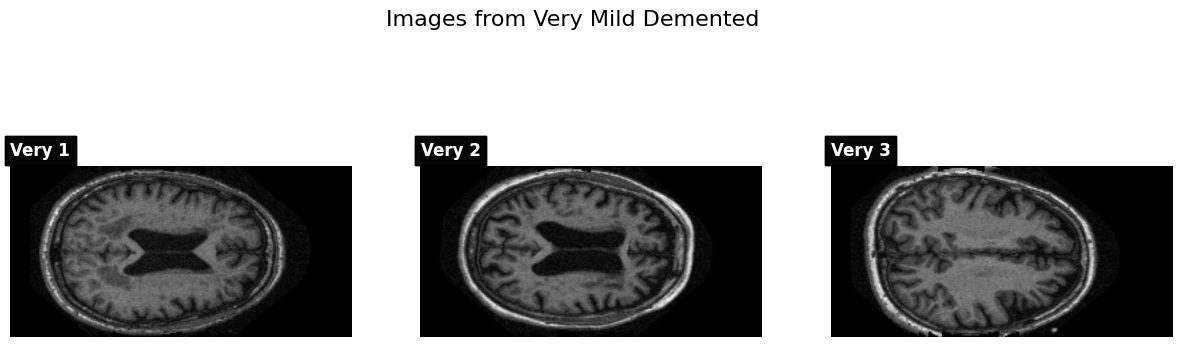

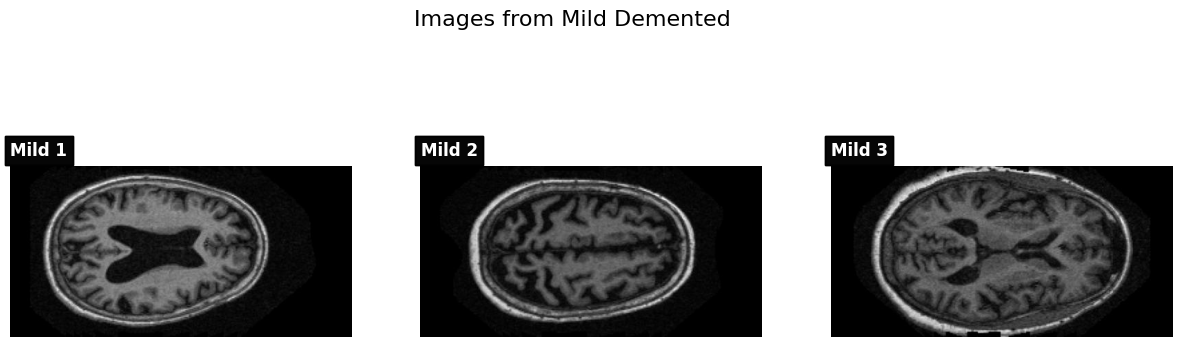

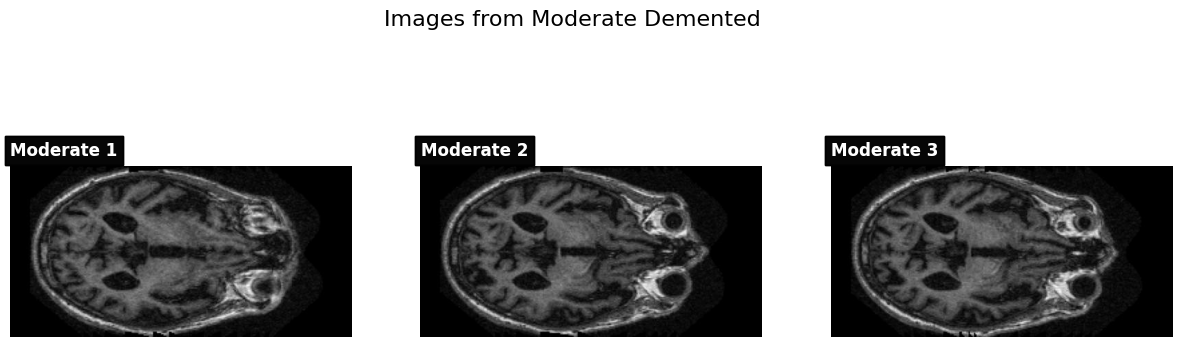

In [6]:
# Function to display images with text indicating the category
def display_images_with_text(file_paths, category_name, endings=['150', '151', '152']):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Images from {category_name}", fontsize=16)

    for ending in endings:
        matching_files = [img for img in file_paths if img.endswith(ending + '.jpg')]
        for i in range(min(3, len(matching_files))):
            img_path = matching_files[i]
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Add text indicating the category
            plt.text(0, -10, f"{category_name.split()[0]} {i + 1}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()

# Display images with text for each category
display_images_with_text(non_demented, "Non Demented")
display_images_with_text(very_mild_demented, "Very Mild Demented")
display_images_with_text(mild_demented, "Mild Demented")
display_images_with_text(moderate_demented, "Moderate Demented")

In [7]:
def get_info_from_filename(filename):
    pattern = re.compile('OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    patient_id = match.group(1)
    mr_id = match.group(2)
    scan_id = match.group(3)
    layer_id = match.group(4)

    return patient_id, mr_id, scan_id, layer_id

In [8]:
def create_ref_df(dataset_path):
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []

    # Iterate through folders in the dataset_path
    for folder in os.listdir(dataset_path):
        
        # Iterate through files in each folder
        for file in os.listdir(os.path.join(dataset_path, folder)):

            # Extract information from the filename using get_info_from_filename function
            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)

            # Append information to respective lists
            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)

    # Create a DataFrame from the collected information
    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels,
        'patient_id': patient_ids,
        'mr_id': mr_ids,
        'scan_id': scan_ids,
        'layer_id': layer_ids
    })

    # Convert columns to appropriate data types
    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
        'patient_id': 'int64',
        'mr_id': 'int64',
        'scan_id': 'int64',
        'layer_id': 'int64'
    })

    return ref_df

In [9]:
# Applying the function defined above
ref_df = create_ref_df('/kaggle/input/imagesoasis/Data')

In [10]:
def load_images(ref_df):
    labels = []
    images = []
    paths = []

    # Iterate through rows of the reference DataFrame
    for idx, row in tqdm(ref_df.iterrows(), total=ref_df.shape[0]):
        
        # Load image using PIL and convert it to a grayscale numpy array
        images.append(np.array(Image.open(row['path']).convert('L')))
        
        # Append label and path to respective lists
        labels.append(row['label'])
        paths.append(row['path'])
    
    # Return lists of images, labels, and paths
    return images, labels, paths

In [11]:

images, labels, paths = load_images(ref_df)

100%|██████████| 86437/86437 [09:58<00:00, 144.47it/s]


In [12]:
def get_image_stats(images, labels, paths):
    means, stds, widths, heights = [], [], [], []
    skewnesses = []
    
    # Iterate through the images
    for image in tqdm(images):
        
        # Calculate mean and standard deviation
        means.append(np.mean(image))
        stds.append(np.std(image))
        
        # Get image width and height
        widths.append(image.shape[0])
        heights.append(image.shape[1])
        
        # Calculate skewness of the image histogram
        image_hist = np.histogram(image.flatten())[0]
        skewnesses.append(skew(image_hist))
    
    # Create a DataFrame with image statistics
    image_stats = pd.DataFrame({
        'mean': means,
        'std': stds,
        'width': widths,
        'height': heights,
        'skew': skewnesses
    })
    
    # Add labels and paths to the DataFrame
    image_stats['label'] = labels
    image_stats['path'] = paths
    
    return image_stats

In [13]:
# Applying the function defined above
image_stats = get_image_stats(images, labels, paths)

100%|██████████| 86437/86437 [04:15<00:00, 338.29it/s]


# Training Data

In [14]:
# Set seed for random sampling
random.seed(42)


# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

In [15]:
# Check number of train images per category
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

53777
10980
4001
390


In [16]:
# Specify the target number of samples for each class
target_samples = 5000

# Oversample small classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)
mild_demented_samp = random.choices(mild_demented_train, k=target_samples)

# Undersample large classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)

In [17]:
# Check results
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

5000
5000
5000
5000


# Test Data

In [18]:
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

13445
2745
1001
98


In [19]:
# Specify the target number of samples for each class
target_samples = 640

# Undersample large classes
mild_demented_test = random.sample(mild_demented_test, k=target_samples)
very_mild_demented_test = random.sample(very_mild_demented_test, k=target_samples)
non_demented_test = random.sample(non_demented_test, k=target_samples)

# Merge Shaping

In [20]:
# One-hot encoder for class labels 
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

# Splitting Dataset

## Dataset dan Label

In [21]:
# Empty objects to store the data and the class labels (result) in
data = []
result = []

# Loop through each category and transform data and result into right format (128x128x3 & one-hot encoded) 
# and merge categories together
for path in non_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        
for path in mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray()) 
        
for path in moderate_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [22]:
# Transform data to numpy array
data = np.array(data)

# Check shape
data.shape

(20000, 128, 128, 3)

In [23]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format 
result = result.reshape((data.shape[0],4)) 

# Check shape 
result.shape

(20000, 4)

## Data Splitting

In [24]:
# Split in validation and train data 
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

## Data Testing

In [25]:
### Transforming the data into the right shape (128x128x3), merge and encode it 

data_test = []
result_test = []

for path in non_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[0]]).toarray())
        
for path in very_mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[1]]).toarray())
        
for path in mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[2]]).toarray()) 
        
for path in moderate_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[3]]).toarray())

In [26]:
# Transform data to numpy array
data_test = np.array(data_test)
data_test.shape

(2018, 128, 128, 3)

In [27]:
# Transform labels to numpy array
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4)) 
result_test.shape

(2018, 4)

In [28]:
# Change names to x_test and y_test 
x_test = data_test
y_test = result_test

In [29]:
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

# Modelling

In [30]:
# Load the pre-trained EfficientNetB0 model without top (classification) layers
pretrained_base_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Make the weights of the pretrained base trainable ("unfreeze")
pretrained_base_EfficientNetB0.trainable = True

# Create a custom model on top of the pre-trained base
model_EfficientNetB0 = models.Sequential([
    pretrained_base_EfficientNetB0,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(), # reduces feature maps to a single value, so no additional 'flatten' layer needed (also reduces the nr of parameters)
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_EfficientNetB0.build(input_shape=(None, 128, 128, 3)) 
# Summary of the model
model_EfficientNetB0.summary()
model_EfficientNetB0_rc_l1 = clone_model(model_EfficientNetB0)

I0000 00:00:1731534483.269613      24 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,615 (17.98 MB)

 Trainable params: 4,668,032 (17.81 MB)

 Non-trainable params: 44,583 (174.16 KB)

# Hyperparameter Tunning

In [31]:
# #Define a function to create the model
# def create_model(hidden_units=256, dropout_rate=0.5, learning_rate=0.001):
#     model = Sequential([
#             pretrained_base_EfficientNetB0,
#             BatchNormalization(),
#             GlobalAveragePooling2D(),
#             Dense(hidden_units, activation='relu'),
#             Dropout(dropout_rate),
#             Dense(4, activation='softmax')
#         ])
    
#         # Train the pretrained base
#     model.layers[0].trainable = True
    
#     optimizer = Adam(learning_rate=learning_rate)
    
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model


#     # Specify values for grid search
    
# hidden_units_values = [128, 256, 512]
# dropout_rate_values = [0.3, 0.5, 0.7]
# learning_rate_values = [0.001, 0.01, 0.1]
# batch_size_values = [16, 32, 64]


#     # 1: Tune dropout rate and hidden units

# best_accuracy = 0
# best_params = {}

# for hidden_units in hidden_units_values:
#     for dropout_rate in dropout_rate_values:
#             # Create model
#         model = create_model(hidden_units=hidden_units, dropout_rate=dropout_rate)

#             # Train model
#         history = model.fit(x_train, y_train_int, epochs=5, batch_size=32, # 5 epochs to reduce computation time
#                             validation_data=(x_val, y_val_int))

#             # Evaluate model on validation set
#         accuracy = model.evaluate(x_val, y_val_int)[1]

#             # Print or store the results
#         print(f'Hidden Units: {hidden_units}, Dropout Rate: {dropout_rate}, Accuracy: {accuracy}')

#             # Update best parameters if needed
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_params = {'hidden_units': hidden_units, 'dropout_rate': dropout_rate}
            
#     # Print the best hyperparameters

# print(f'Best Hyperparameters: {best_params}')


#     # 2: Tune batch size and learning rate

# best_accuracy_2 = 0
# best_params_2 = {}
# for learning_rate in learning_rate_values:
#     for batch_size in batch_size_values:
#             # Create model
#         model = create_model(hidden_units=best_params['hidden_units'], dropout_rate=best_params['dropout_rate'],
#         learning_rate=learning_rate)

#             # Train model
#         history = model.fit(x_train, y_train_int, epochs=5, batch_size=batch_size, 
#                             validation_data=(x_val, y_val_int))

#             # Evaluate model on validation set
#         accuracy = model.evaluate(x_val, y_val_int)[1]

#             # Print or store the results
#         print(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}, Accuracy: {accuracy}')

#             # Update best parameters if needed
#         if accuracy > best_accuracy_2:
#             best_accuracy_2 = accuracy
#             best_params_2.update({'learning_rate': learning_rate, 'batch_size': batch_size})

#     # Print the best hyperparameters

# print(f'Best Hyperparameters: {best_params_2}')

### 4.5 Training: Regular Classification

## Default

In [32]:
# Store model architecture in new object, to prevent confusion (e.g. with compiling, training and calculating test accuracy later)
# By cloning the model
model_EfficientNetB0_rc = clone_model(model_EfficientNetB0)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

# Train
history_EfficientNetB0_reguler = model_EfficientNetB0.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val))

Epoch 1/50


I0000 00:00:1731534530.718258      97 service.cc:148] XLA service 0x7e0158004480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731534530.718293      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731534535.512835      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1731534542.453799      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731534542.636880      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731534542.993908      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731534543.1834

   3/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.3090 - loss: 1.5536    

I0000 00:00:1731534563.586452      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 33ms/step - accuracy: 0.7207 - loss: 0.6919 - val_accuracy: 0.7825 - val_loss: 1.0405
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9118 - loss: 0.2467 - val_accuracy: 0.9455 - val_loss: 0.1458
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9457 - loss: 0.1475 - val_accuracy: 0.9505 - val_loss: 0.1522
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9523 - loss: 0.1374 - val_accuracy: 0.9760 - val_loss: 0.0706
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9696 - loss: 0.0905 - val_accuracy: 0.9415 - val_loss: 0.1883
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9620 - loss: 0.1181 - val_accuracy: 0.9580 - val_loss: 0.1475
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9763 - loss: 0.0739 - val_accuracy: 0.9440 - val_loss: 0.1941
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9819 - loss: 0.05

In [33]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set 
testeval = model_EfficientNetB0.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 11s - 174ms/step - accuracy: 0.9960 - loss: 0.0090
Test Loss: 0.008987653069198132
Test Accuracy: 0.9960356950759888


## Early Stopping

In [34]:
# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0_rc.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

# Train
history_EfficientNetB0_early_stopping = model_EfficientNetB0_rc.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 34ms/step - accuracy: 0.5482 - loss: 1.2399 - val_accuracy: 0.8380 - val_loss: 0.3622
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8598 - loss: 0.3677 - val_accuracy: 0.8240 - val_loss: 0.5159
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9195 - loss: 0.2172 - val_accuracy: 0.9342 - val_loss: 0.1778
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9388 - loss: 0.1749 - val_accuracy: 0.9513 - val_loss: 0.1678
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9497 - loss: 0.1522 - val_accuracy: 0.9620 - val_loss: 0.1091
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.9602 - loss: 0.1176 - val_accuracy: 0.9712 - val_loss: 0.0895
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.9687 - loss: 0.0963 - val_accuracy: 0.9580 - val_loss: 0.1138
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9699 -

## Reduce Learning Rate on Plateu

In [35]:
model_EfficientNetB0_plateu = clone_model(model_EfficientNetB0)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0_plateu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)


In [36]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
history_EfficientNetB0_reduce_lr = model_EfficientNetB0_plateu.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping,model_rlr])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.5122 - loss: 1.2823 - val_accuracy: 0.8282 - val_loss: 0.3943 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8763 - loss: 0.3276 - val_accuracy: 0.9227 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9242 - loss: 0.2123 - val_accuracy: 0.9507 - val_loss: 0.1377 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9463 - loss: 0.1595 - val_accuracy: 0.9122 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9560 - loss: 0.1393 - val_accuracy: 0.9218 - val_loss: 0.2085 - learning_rate: 0.0010
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9607 - loss: 0.1226 - val_accuracy: 0.9682 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accura

In [37]:
model_EfficientNetB0_LRPlateuOnly = clone_model(model_EfficientNetB0)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)
# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)
# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0_LRPlateuOnly.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Define early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

In [38]:
# Train
history_EfficientNetB0_reduce_lr_only = model_EfficientNetB0_LRPlateuOnly.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[model_rlr])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.5238 - loss: 1.2347 - val_accuracy: 0.8580 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8685 - loss: 0.3518 - val_accuracy: 0.8763 - val_loss: 0.3453 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9214 - loss: 0.2266 - val_accuracy: 0.8525 - val_loss: 0.4051 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9392 - loss: 0.1728 - val_accuracy: 0.9105 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9519 - loss: 0.1419 - val_accuracy: 0.9287 - val_loss: 0.1926 - learning_rate: 0.0010
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9661 - loss: 0.1029 - val_accuracy: 0.9668 - val_loss: 0.1039 - learning_rate: 0.0010
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accura

# 4. Regularization

In [39]:
from keras import regularizers
# Load the pre-trained EfficientNetB0 model without top (classification) layers
pretrained_base_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Make the weights of the pretrained base trainable ("unfreeze")
pretrained_base_EfficientNetB0.trainable = True

# Create a custom model on top of the pre-trained base
model_EfficientNetB0L2 = models.Sequential([
    pretrained_base_EfficientNetB0,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(), # reduces feature maps to a single value, so no additional 'flatten' layer needed (also reduces the nr of parameters)
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model_EfficientNetB0L2.build(input_shape=(None, 128, 128, 3)) 
# Summary of the model
model_EfficientNetB0L2.summary()
model_EfficientNetB0LR_plateu = clone_model(model_EfficientNetB0L2)
model_EfficientNetB0LR_plateu_Only = clone_model(model_EfficientNetB0L2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,615 (17.98 MB)

 Trainable params: 4,668,032 (17.81 MB)

 Non-trainable params: 44,583 (174.16 KB)

## 4.1 Default Regularization L2

In [40]:
# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0L2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
history_EfficientNetB0L2_default = model_EfficientNetB0L2.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val))

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 33ms/step - accuracy: 0.7323 - loss: 2.7574 - val_accuracy: 0.8637 - val_loss: 0.4921
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9159 - loss: 0.3400 - val_accuracy: 0.9643 - val_loss: 0.1737
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9442 - loss: 0.2629 - val_accuracy: 0.9277 - val_loss: 0.3594
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9557 - loss: 0.2209 - val_accuracy: 0.9665 - val_loss: 0.1596
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9657 - loss: 0.1704 - val_accuracy: 0.9758 - val_loss: 0.1184
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9733 - loss: 0.1589 - val_accuracy: 0.9803 - val_loss: 0.1029
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9789 - loss: 0.1232 - val_accuracy: 0.9695 - val_loss: 0.1278
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9775 -

## 4.2 Regularization and Reduce Learning Rate

In [41]:

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0LR_plateu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
history_EfficientNetB0L2_ReduceLR = model_EfficientNetB0LR_plateu.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping,model_rlr])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 91s 33ms/step - accuracy: 0.5308 - loss: 3.7328 - val_accuracy: 0.8602 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8646 - loss: 0.4054 - val_accuracy: 0.8780 - val_loss: 0.3909 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9177 - loss: 0.2996 - val_accuracy: 0.9525 - val_loss: 0.1800 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9399 - loss: 0.2361 - val_accuracy: 0.9250 - val_loss: 0.2793 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9549 - loss: 0.1975 - val_accuracy: 0.9635 - val_loss: 0.1342 - learning_rate: 0.0010


## Plateu Only

In [42]:

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0LR_plateu_Only.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
history_EfficientNetB0L2_ReduceLR_only = model_EfficientNetB0LR_plateu_Only.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[model_rlr])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 33ms/step - accuracy: 0.5077 - loss: 3.7235 - val_accuracy: 0.8152 - val_loss: 0.7049 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8661 - loss: 0.4152 - val_accuracy: 0.9187 - val_loss: 0.2792 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9132 - loss: 0.3013 - val_accuracy: 0.9235 - val_loss: 0.3322 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9384 - loss: 0.2662 - val_accuracy: 0.9592 - val_loss: 0.1606 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9620 - loss: 0.1715 - val_accuracy: 0.9638 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9638 - loss: 0.1707 - val_accuracy: 0.9423 - val_loss: 0.2173 - learning_rate: 0.0010
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accura

In [43]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Refer to: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label',fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    fontsize=20,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Modelling Regularization L1 

In [44]:
from keras import regularizers
# Load the pre-trained EfficientNetB0 model without top (classification) layers
pretrained_base_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Make the weights of the pretrained base trainable ("unfreeze")
pretrained_base_EfficientNetB0.trainable = True

# Create a custom model on top of the pre-trained base
model_EfficientNetB0L1 = models.Sequential([
    pretrained_base_EfficientNetB0,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(), # reduces feature maps to a single value, so no additional 'flatten' layer needed (also reduces the nr of parameters)
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model_EfficientNetB0L1.build(input_shape=(None, 128, 128, 3)) 
# Summary of the model
model_EfficientNetB0L1.summary()
model_EfficientNetB0_L1_LR_plateu = clone_model(model_EfficientNetB0L1)
model_EfficientNetB0_L1_LR_plateu_Only = clone_model(model_EfficientNetB0L1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,712,615 (17.98 MB)

 Trainable params: 4,668,032 (17.81 MB)

 Non-trainable params: 44,583 (174.16 KB)

## Default L1

In [45]:

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0L1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
history_EfficientNetB0L1_default = model_EfficientNetB0L1.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val))

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 96s 34ms/step - accuracy: 0.6939 - loss: 21.7944 - val_accuracy: 0.8813 - val_loss: 1.7658
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8837 - loss: 1.9769 - val_accuracy: 0.9270 - val_loss: 4.0319
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.9271 - loss: 1.6334 - val_accuracy: 0.9550 - val_loss: 1.3447
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9479 - loss: 1.2778 - val_accuracy: 0.9837 - val_loss: 1.0573
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9710 - loss: 1.0596 - val_accuracy: 0.9550 - val_loss: 0.9779
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9746 - loss: 1.0021 - val_accuracy: 0.9530 - val_loss: 0.9881
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9760 - loss: 0.9939 - val_accuracy: 0.9825 - val_loss: 1.0103
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9824 

## L1 and Reduce Learning Rate and Early Stopping

In [46]:

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0_L1_LR_plateu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
History_model_EfficientNetB0_L1_LR_plateu = model_EfficientNetB0_L1_LR_plateu.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping,model_rlr])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 34ms/step - accuracy: 0.4803 - loss: 22.8166 - val_accuracy: 0.3792 - val_loss: 3.0721 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.7436 - loss: 2.2097 - val_accuracy: 0.7845 - val_loss: 2.4738 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8268 - loss: 2.0188 - val_accuracy: 0.8618 - val_loss: 1.7561 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8808 - loss: 1.9423 - val_accuracy: 0.9028 - val_loss: 1.5370 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9318 - loss: 1.3750 - val_accuracy: 0.9517 - val_loss: 1.0208 - learning_rate: 0.0010


## Regularization With Only Reduce LR

In [47]:

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile with ('regular') categorical_crossentropy 
model_EfficientNetB0_L1_LR_plateu_Only.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-5, patience=4, verbose=False)
# Train
history_EfficientNetB0L2_ReduceLR_only = model_EfficientNetB0_L1_LR_plateu_Only.fit(x_train, y_train, epochs=50, batch_size=16, 
                                                       verbose=1, validation_data=(x_val, y_val), callbacks=[model_rlr])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 33ms/step - accuracy: 0.4507 - loss: 23.1437 - val_accuracy: 0.6615 - val_loss: 2.2686 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.7464 - loss: 2.1748 - val_accuracy: 0.8655 - val_loss: 1.8912 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8372 - loss: 1.8988 - val_accuracy: 0.9170 - val_loss: 1.9151 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8826 - loss: 1.9972 - val_accuracy: 0.9465 - val_loss: 1.4861 - learning_rate: 0.0010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.7990 - loss: 2.0964 - val_accuracy: 0.9205 - val_loss: 1.0866 - learning_rate: 0.0010
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9189 - loss: 1.1585 - val_accuracy: 0.9647 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accur

# Hasil

## 5.1 Tanpa Regularization

### 5.1.1 Hasil Default Reguler Clasification

<Axes: >

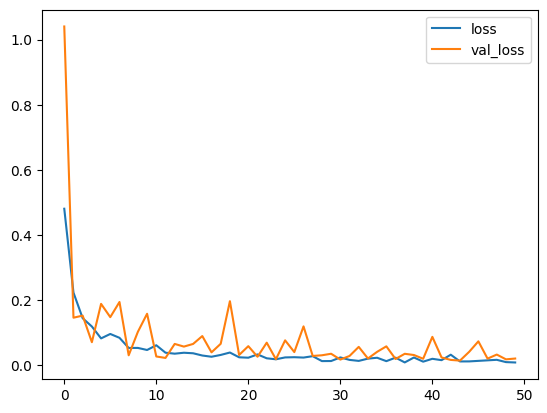

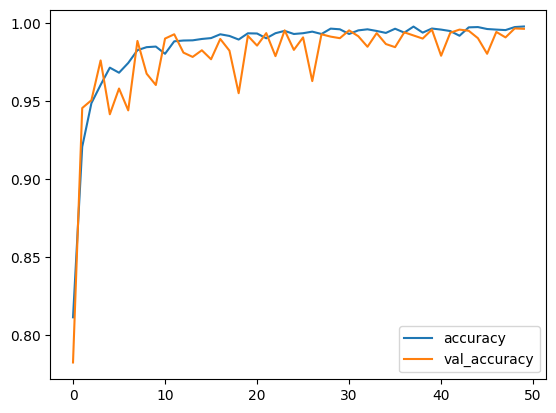

In [48]:
# Loss & accuracy of regular model 
history_EfficientNetB0_reguler_frame = pd.DataFrame(history_EfficientNetB0_reguler.history)
history_EfficientNetB0_reguler_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_reguler_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

### 5.1.2 Hasil Default Early Stopping

<Axes: >

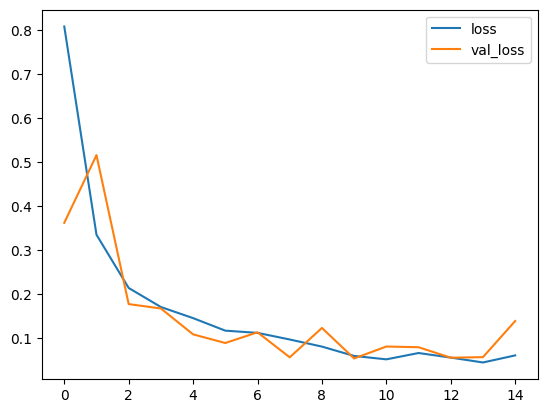

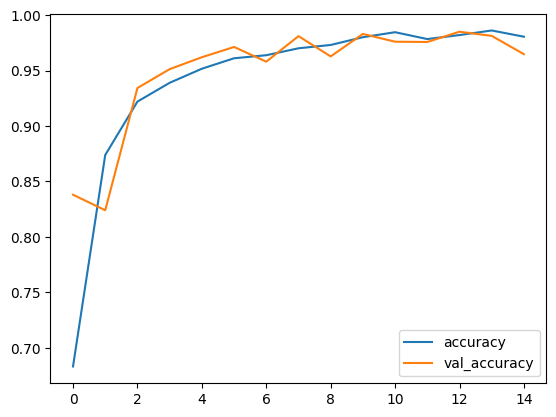

In [49]:
# Loss & accuracy of ordinal model 
history_EfficientNetB0_early_stopping_frame = pd.DataFrame(history_EfficientNetB0_early_stopping.history)
history_EfficientNetB0_early_stopping_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_early_stopping_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

### 5.1.3 Hasil Reduce on Plateu

<Axes: >

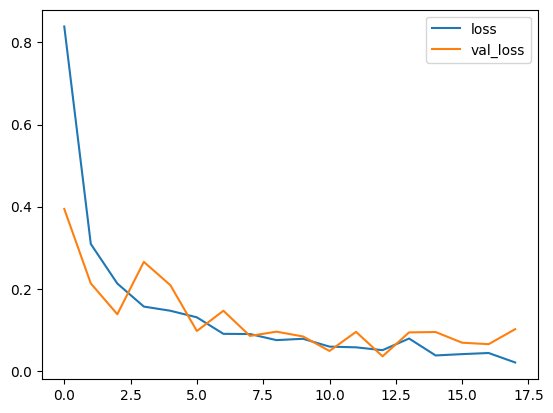

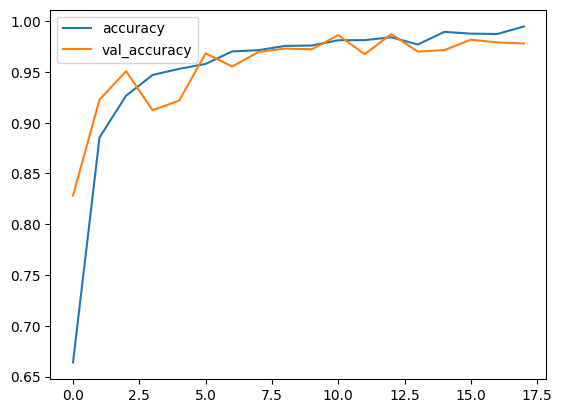

In [50]:
history_EfficientNetB0_reduce_lr_Plateu_frame = pd.DataFrame(history_EfficientNetB0_reduce_lr.history)
history_EfficientNetB0_reduce_lr_Plateu_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_reduce_lr_Plateu_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

## 5.2 Hasil Dengan Regularization

### 5.2.1 Regularization Default

<Axes: >

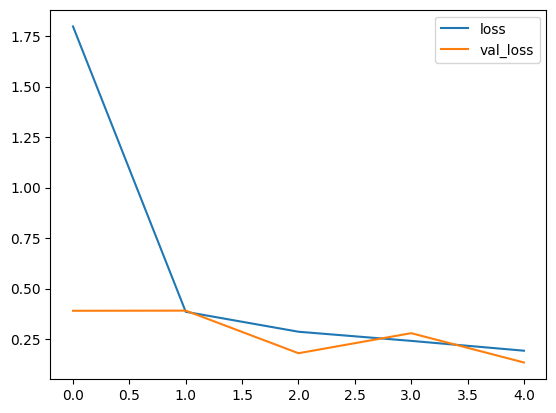

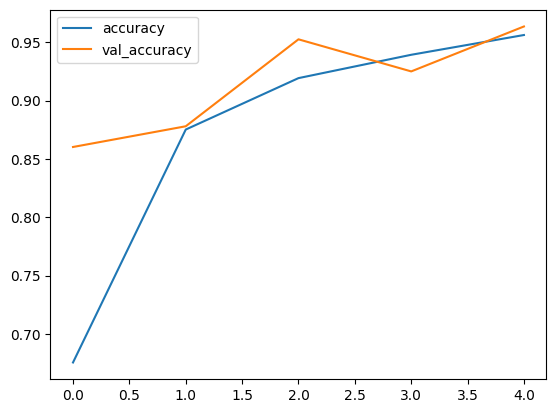

In [51]:
# Loss & accuracy of ordinal model 
history_EfficientNetB0_reduce_lr_Plateu_frame = pd.DataFrame(history_EfficientNetB0L2_ReduceLR.history)
history_EfficientNetB0_reduce_lr_Plateu_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_reduce_lr_Plateu_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

<Axes: >

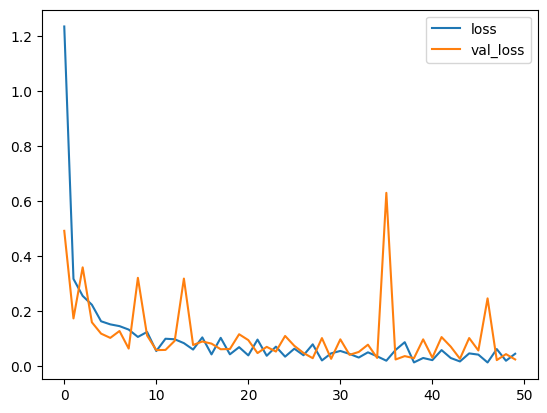

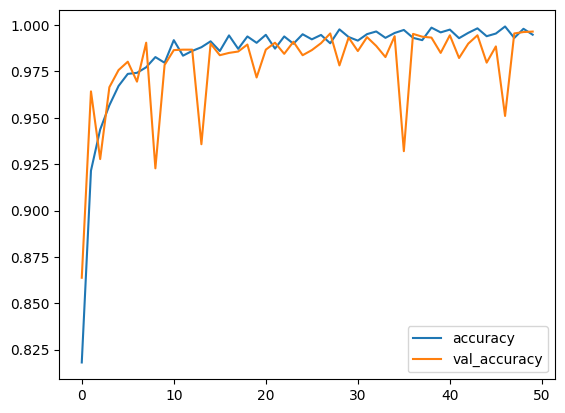

In [52]:
history_EfficientNetB0_early_stopping_frame = pd.DataFrame(history_EfficientNetB0L2_default.history)
history_EfficientNetB0_early_stopping_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_early_stopping_frame.loc[:, ['accuracy', 'val_accuracy']].plot()


## Regularization Reduce LR Only

<Axes: >

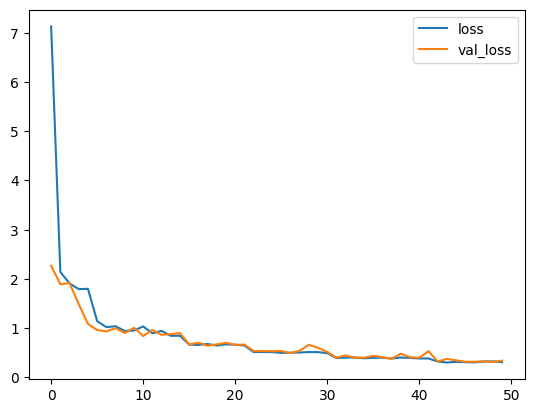

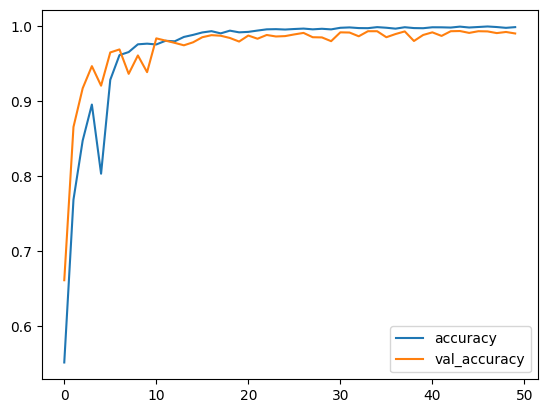

In [53]:
history_EfficientNetB0_reduce_lr_Plateu_only_frame = pd.DataFrame(history_EfficientNetB0L2_ReduceLR_only.history)
history_EfficientNetB0_reduce_lr_Plateu_only_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_reduce_lr_Plateu_only_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

## Regularization L1 

<Axes: >

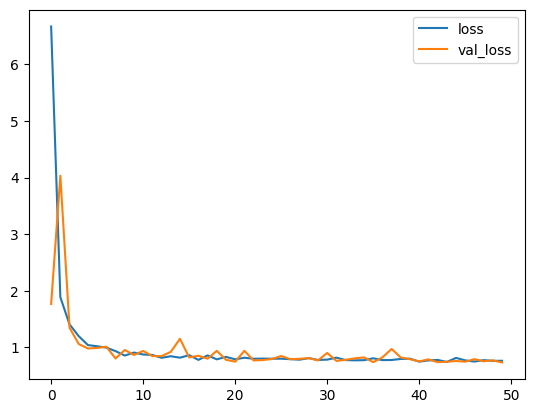

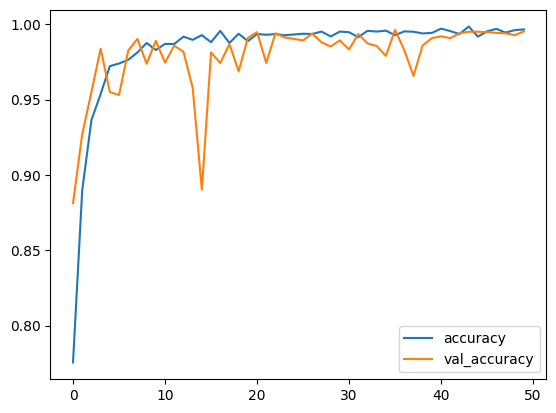

In [54]:
# Loss & accuracy of regular model 
history_EfficientNetB0L1_reguler_frame = pd.DataFrame(history_EfficientNetB0L1_default.history)
history_EfficientNetB0L1_reguler_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0L1_reguler_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

## Regularization L1 + Reduce LR

<Axes: >

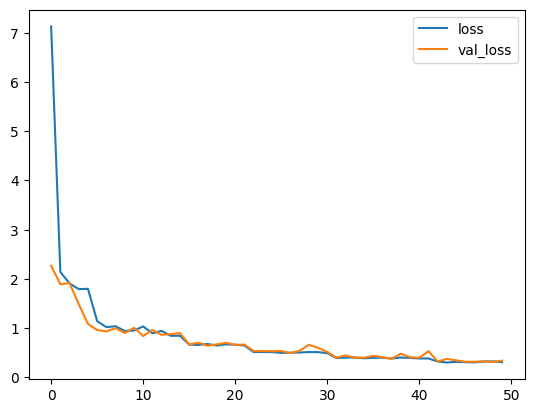

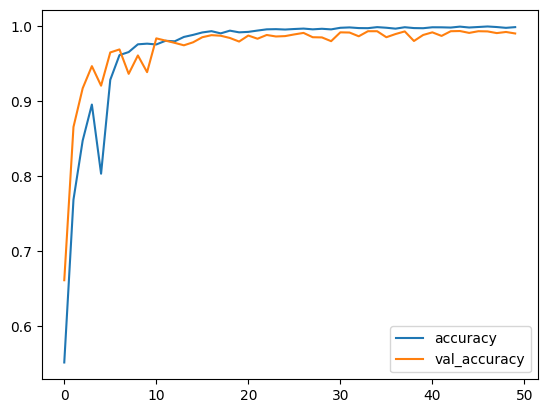

In [55]:
# Loss & accuracy of L1 +Reduce LR
history_EfficientNetB0L1_LR_frame = pd.DataFrame(history_EfficientNetB0L2_ReduceLR_only.history)
history_EfficientNetB0L1_LR_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0L1_LR_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

Regularization L1 + Reduce LR +Early Stopping

<Axes: >

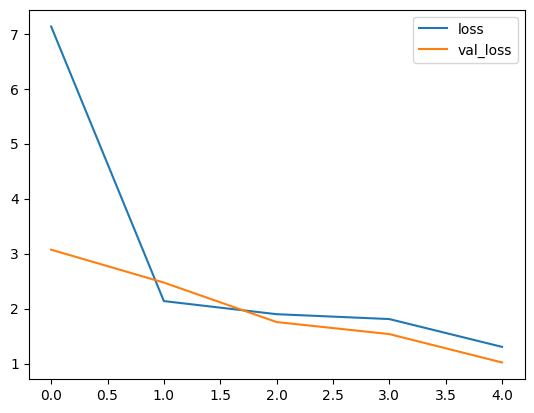

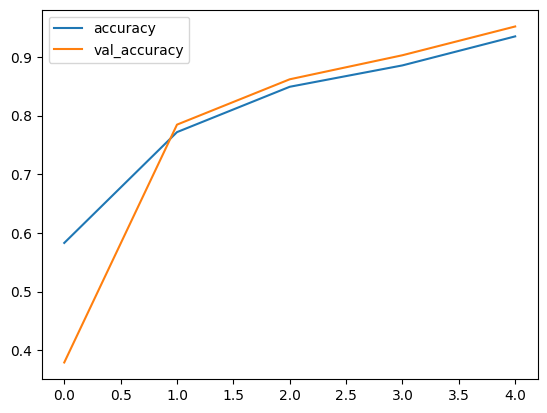

In [56]:

# Loss & accuracy of L1 +Reduce LR
history_EfficientNetB0L1_LR_ES_frame = pd.DataFrame(History_model_EfficientNetB0_L1_LR_plateu.history)
history_EfficientNetB0L1_LR_ES_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0L1_LR_ES_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# 8. Evaluation

### 8.1 Evaluation Classification Default

In [57]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set 
testeval = model_EfficientNetB0.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 1s - 10ms/step - accuracy: 0.9960 - loss: 0.0090
Test Loss: 0.008987653069198132
Test Accuracy: 0.9960356950759888


### 8.1.2 Confusion Metric

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step
Normalized confusion matrix
[[0.990625 0.009375 0.       0.      ]
 [0.003125 0.996875 0.       0.      ]
 [0.       0.       1.       0.      ]
 [0.       0.       0.       1.      ]]


<Axes: title={'center': 'Confusion Matrix Ordinal Classification'}, xlabel='Predicted label', ylabel='True label'>

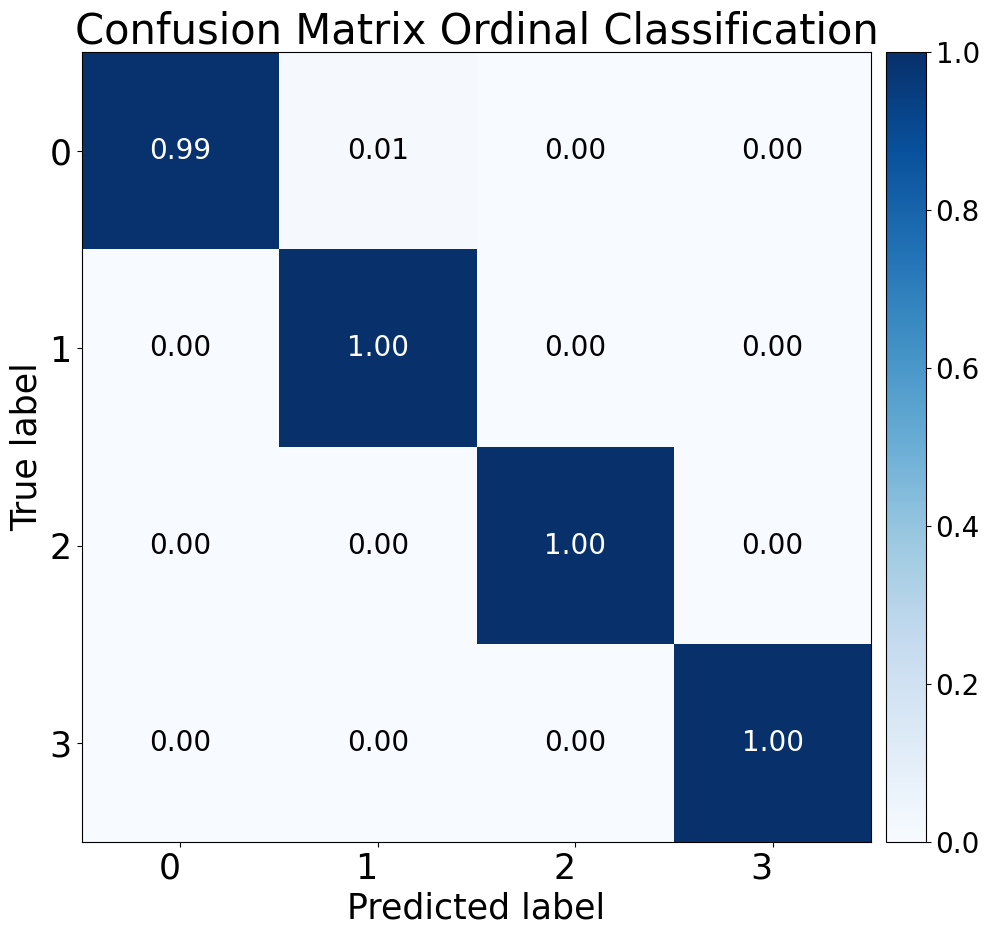

In [58]:
y_pred_int = np.argmax(model_EfficientNetB0.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Matrix Ordinal Classification')

In [59]:
# Predicted integer labels: y_pred_int

# One-hot encode the predicted labels
y_pred_one_hot = to_categorical(y_pred_int, num_classes=4)

# True labels one hot encoded: y_test

# True labels integers: y_test_int

# Calculate precision, recall, and F1 score per class --> uses integers
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages --> uses one hot encoded labels
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_one_hot, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))


Class 0: Precision = 0.9969, Recall = 0.9906, F1 Score = 0.9937
Class 1: Precision = 0.9907, Recall = 0.9969, F1 Score = 0.9938
Class 2: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.996
Micro-average Recall: 0.996
Micro-average F1 Score: 0.996


#### 8.1.3 ROC AUC

In [60]:
# True labels: y_test

# Predicted probability scores for each class
y_probs = model_EfficientNetB0.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 1.0000
Class 1: ROC AUC = 1.0000
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 1.0


In [61]:
Gabungan=[]
data_evaluasi_1={'Model':'EfficientNetB0 ','Treatment':'default','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## 8.2 Results Early Stopping

In [62]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set 
testeval = model_EfficientNetB0_rc.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 10s - 152ms/step - accuracy: 0.9812 - loss: 0.0531
Test Loss: 0.053111638873815536
Test Accuracy: 0.9811694622039795


### 8.2.1 Confusion Metric

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step
Normalized confusion matrix
[[0.9515625 0.0453125 0.003125  0.       ]
 [0.0078125 0.9921875 0.        0.       ]
 [0.003125  0.        0.996875  0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Metric Early Stopping'}, xlabel='Predicted label', ylabel='True label'>

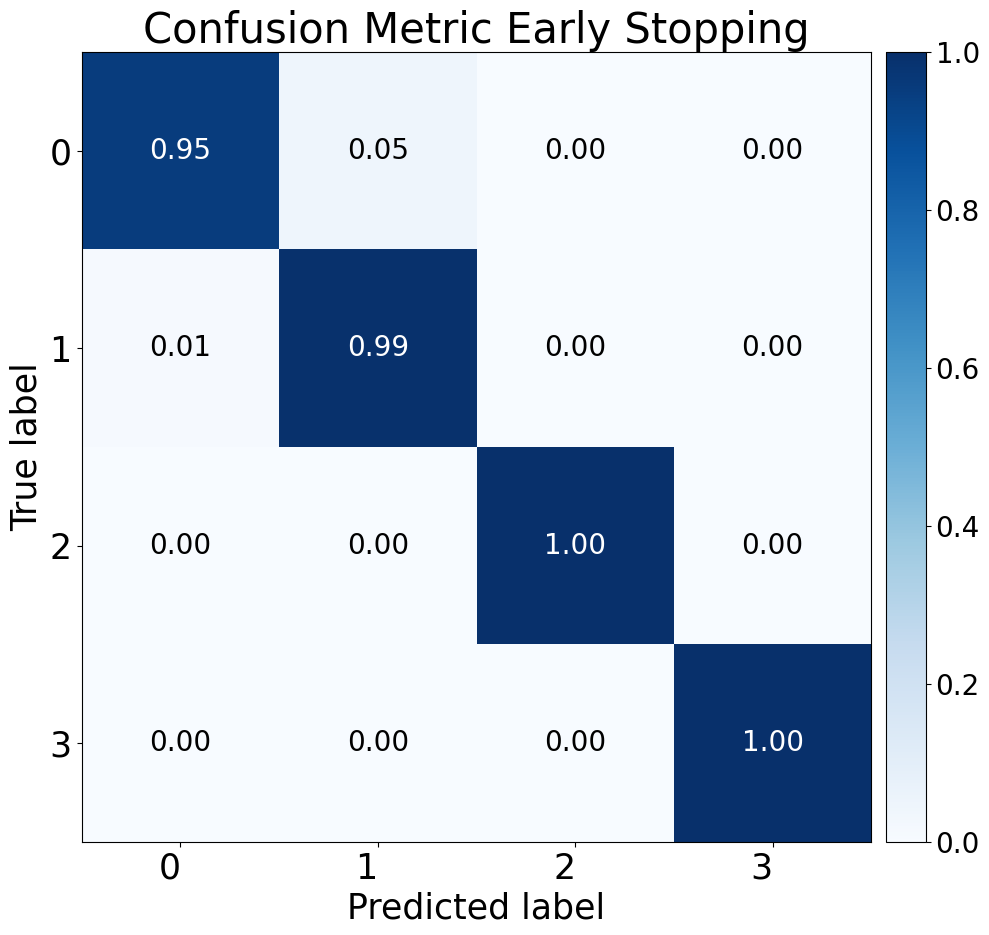

In [63]:
y_pred_rc_int = np.argmax(model_EfficientNetB0_rc.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric Early Stopping')

### 8.2.2 Akurasi F1 Score

In [64]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_rc_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_rc_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9886, Recall = 0.9516, F1 Score = 0.9697
Class 1: Precision = 0.9563, Recall = 0.9922, F1 Score = 0.9739
Class 2: Precision = 0.9969, Recall = 0.9969, F1 Score = 0.9969
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9812
Micro-average Recall: 0.9812
Micro-average F1 Score: 0.9812


### 8.2.3 ROC AUC

In [65]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_rc = model_EfficientNetB0_rc.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 0.9986
Class 1: ROC AUC = 0.9989
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [66]:
data_evaluasi_1={'Model':'Modified EfficientNetB0','Treatment':'Early Stopping','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## 8.3 Reduce Learning Rate

In [67]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set 
testeval = model_EfficientNetB0_plateu.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 9s - 143ms/step - accuracy: 0.9787 - loss: 0.0529
Test Loss: 0.05290786921977997
Test Accuracy: 0.9786917567253113


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step
Normalized confusion matrix
[[0.98125   0.0140625 0.0046875 0.       ]
 [0.0359375 0.95625   0.0078125 0.       ]
 [0.0046875 0.        0.9953125 0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Matrix Reduce Learning Rate'}, xlabel='Predicted label', ylabel='True label'>

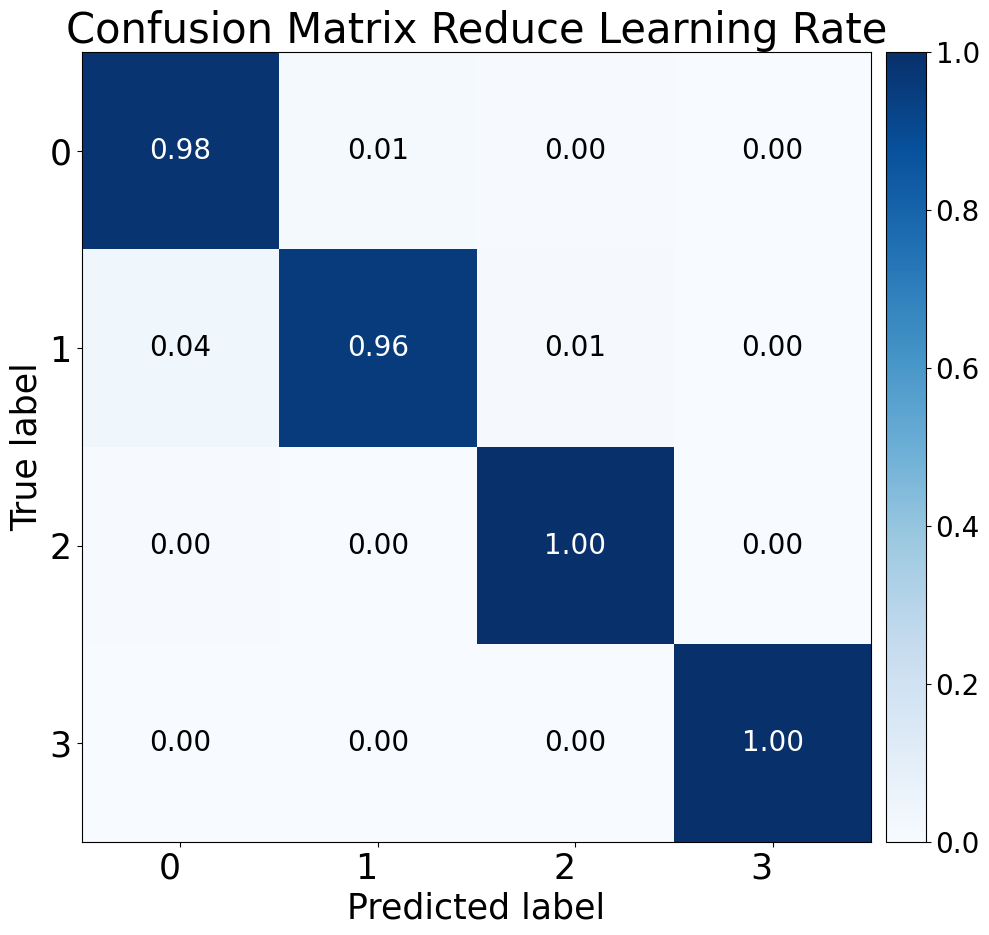

In [68]:
y_pred_int = np.argmax(model_EfficientNetB0_plateu.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Matrix Reduce Learning Rate')

In [69]:
y_pred_one_hot = to_categorical(y_pred_int, num_classes=4)

# True labels one hot encoded: y_test

# True labels integers: y_test_int

# Calculate precision, recall, and F1 score per class --> uses integers
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages --> uses one hot encoded labels
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_one_hot, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))


Class 0: Precision = 0.9602, Recall = 0.9812, F1 Score = 0.9706
Class 1: Precision = 0.9855, Recall = 0.9563, F1 Score = 0.9707
Class 2: Precision = 0.9876, Recall = 0.9953, F1 Score = 0.9914
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9787
Micro-average Recall: 0.9787
Micro-average F1 Score: 0.9787


In [70]:
# True labels: y_test

# Predicted probability scores for each class
y_probs = model_EfficientNetB0_plateu.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Class 0: ROC AUC = 0.9986
Class 1: ROC AUC = 0.9989
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [71]:
data_evaluasi_1={'Model':'Modified EfficientNetB0','Treatment':'Reduce Learning Rate','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## 7.4 Reguler Classification with Regularization

In [72]:
testeval = model_EfficientNetB0L2.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 9s - 148ms/step - accuracy: 0.9975 - loss: 0.0198
Test Loss: 0.019847435876727104
Test Accuracy: 0.9975222945213318


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Normalized confusion matrix
[[0.9953125 0.003125  0.        0.0015625]
 [0.0015625 0.996875  0.0015625 0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Metric L2 '}, xlabel='Predicted label', ylabel='True label'>

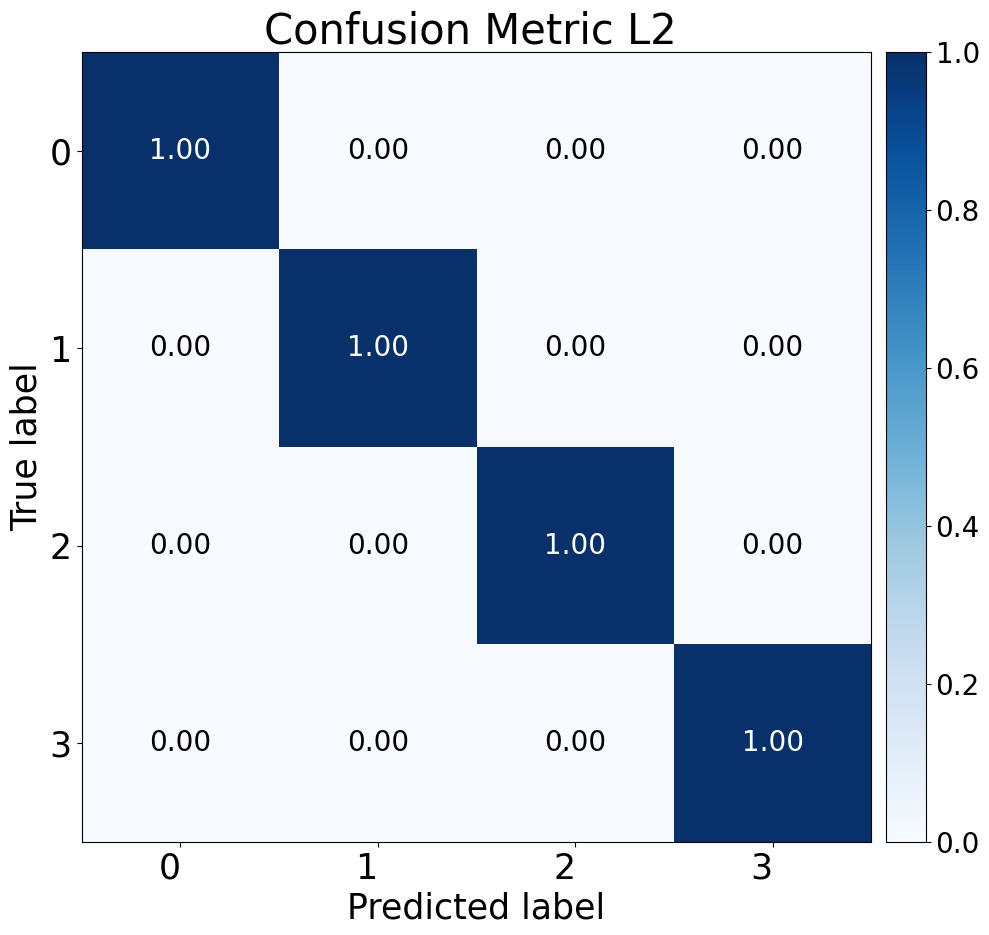

In [73]:
y_pred_l2_rc_int = np.argmax(model_EfficientNetB0L2.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_l2_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric L2 ')

In [74]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_l2_rc_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_l2_rc_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9984, Recall = 0.9953, F1 Score = 0.9969
Class 1: Precision = 0.9969, Recall = 0.9969, F1 Score = 0.9969
Class 2: Precision = 0.9984, Recall = 1.0000, F1 Score = 0.9992
Class 3: Precision = 0.9899, Recall = 1.0000, F1 Score = 0.9949
Micro-average Precision: 0.9975
Micro-average Recall: 0.9975
Micro-average F1 Score: 0.9975


In [75]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_l2_rc = model_EfficientNetB0L2.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_l2_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 1.0000
Class 1: ROC AUC = 1.0000
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [76]:
data_evaluasi_1={'Model':'EfficientNetB0 With L2','Treatment':'L2','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## L2 With Reduce LR

In [77]:
testeval = model_EfficientNetB0_plateu.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 1s - 10ms/step - accuracy: 0.9787 - loss: 0.0529
Test Loss: 0.05290786921977997
Test Accuracy: 0.9786917567253113


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Normalized confusion matrix
[[0.9953125 0.003125  0.        0.0015625]
 [0.0015625 0.996875  0.0015625 0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Metric L2 '}, xlabel='Predicted label', ylabel='True label'>

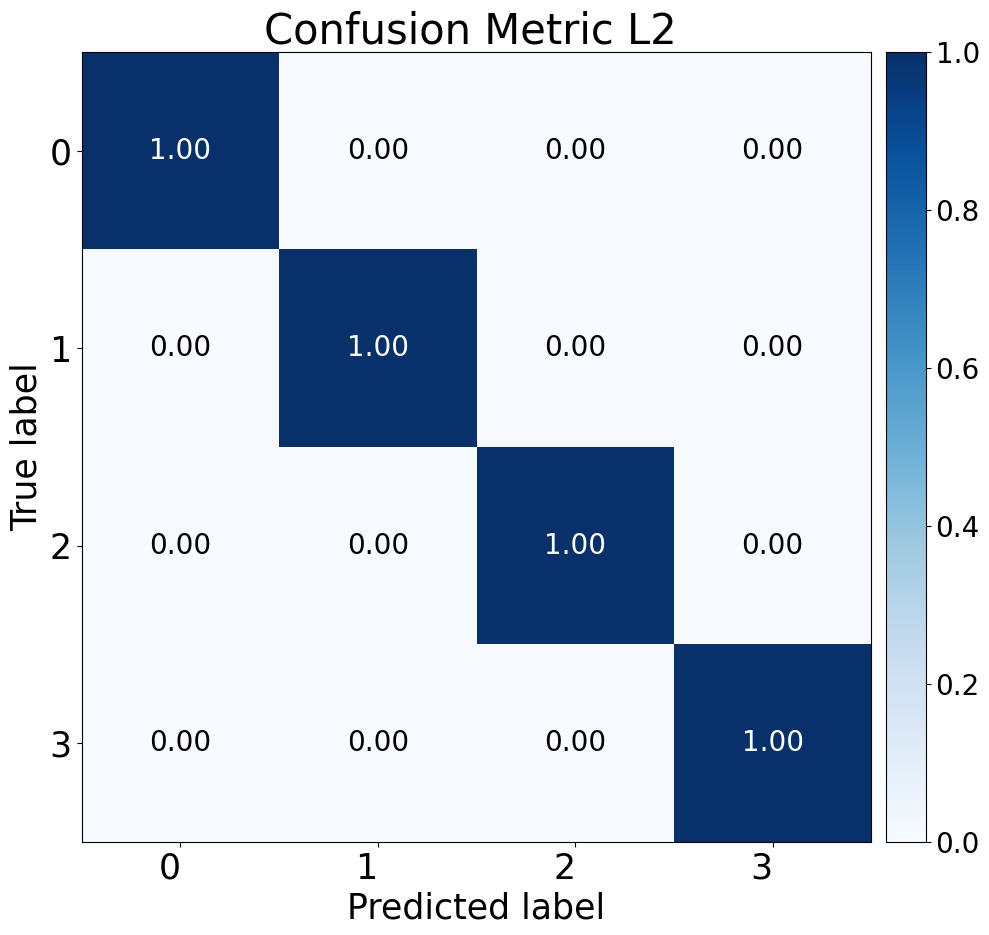

In [78]:
y_pred_l2_rlr_int = np.argmax(model_EfficientNetB0_plateu.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_l2_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric L2 ')

In [79]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_l2_rlr_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_l2_rlr_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9602, Recall = 0.9812, F1 Score = 0.9706
Class 1: Precision = 0.9855, Recall = 0.9563, F1 Score = 0.9707
Class 2: Precision = 0.9876, Recall = 0.9953, F1 Score = 0.9914
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9787
Micro-average Recall: 0.9787
Micro-average F1 Score: 0.9787


In [80]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_l2_rc = model_EfficientNetB0_plateu.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_l2_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 0.9986
Class 1: ROC AUC = 0.9989
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [81]:
data_evaluasi_1={'Model':'EfficientNetB0 With L2','Treatment':'L2+ LR + ES','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## L2 With Reduce LR only

In [82]:
testeval = model_EfficientNetB0LR_plateu_Only.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 9s - 147ms/step - accuracy: 0.9916 - loss: 0.0417
Test Loss: 0.04165428504347801
Test Accuracy: 0.9915758371353149


64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step
Normalized confusion matrix
[[0.9953125 0.003125  0.        0.0015625]
 [0.0015625 0.996875  0.0015625 0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Metric L2 With  Reduce LR '}, xlabel='Predicted label', ylabel='True label'>

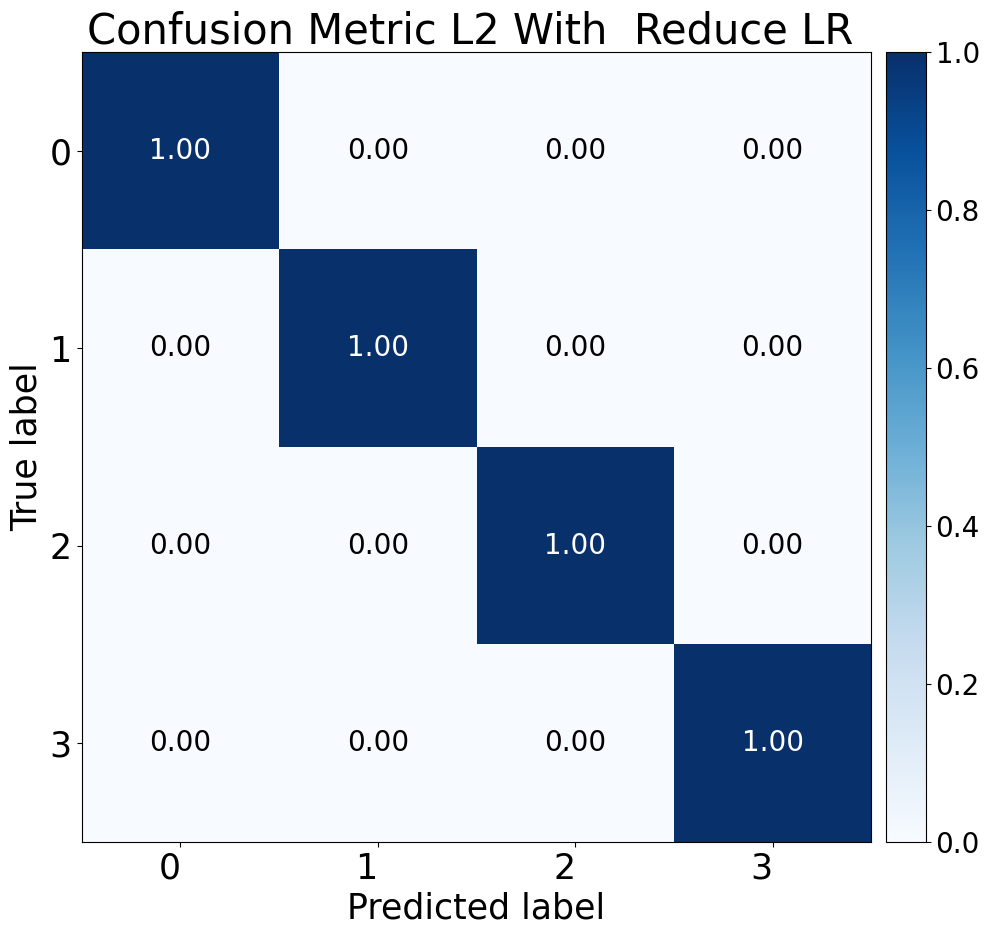

In [83]:
y_pred_l2_rlr_int = np.argmax(model_EfficientNetB0LR_plateu_Only.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_l2_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric L2 With  Reduce LR ')

In [84]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_l2_rlr_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_l2_rlr_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9937, Recall = 0.9797, F1 Score = 0.9866
Class 1: Precision = 0.9845, Recall = 0.9953, F1 Score = 0.9899
Class 2: Precision = 0.9953, Recall = 0.9984, F1 Score = 0.9969
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9916
Micro-average Recall: 0.9916
Micro-average F1 Score: 0.9916


In [85]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_l2_rc = model_EfficientNetB0_plateu.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_l2_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 0.9986
Class 1: ROC AUC = 0.9989
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [86]:
data_evaluasi_1={'Model':'EfficientNetB0 With L2','Treatment':'L2+Reduce LR','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

# Regularization L1

In [87]:
testeval = model_EfficientNetB0L1.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 9s - 145ms/step - accuracy: 0.9955 - loss: 0.7325
Test Loss: 0.7324607372283936
Test Accuracy: 0.9955401420593262


## Confusion Matrix L1

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step
Normalized confusion matrix
[[0.9921875 0.00625   0.0015625 0.       ]
 [0.00625   0.99375   0.        0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Metric L1 '}, xlabel='Predicted label', ylabel='True label'>

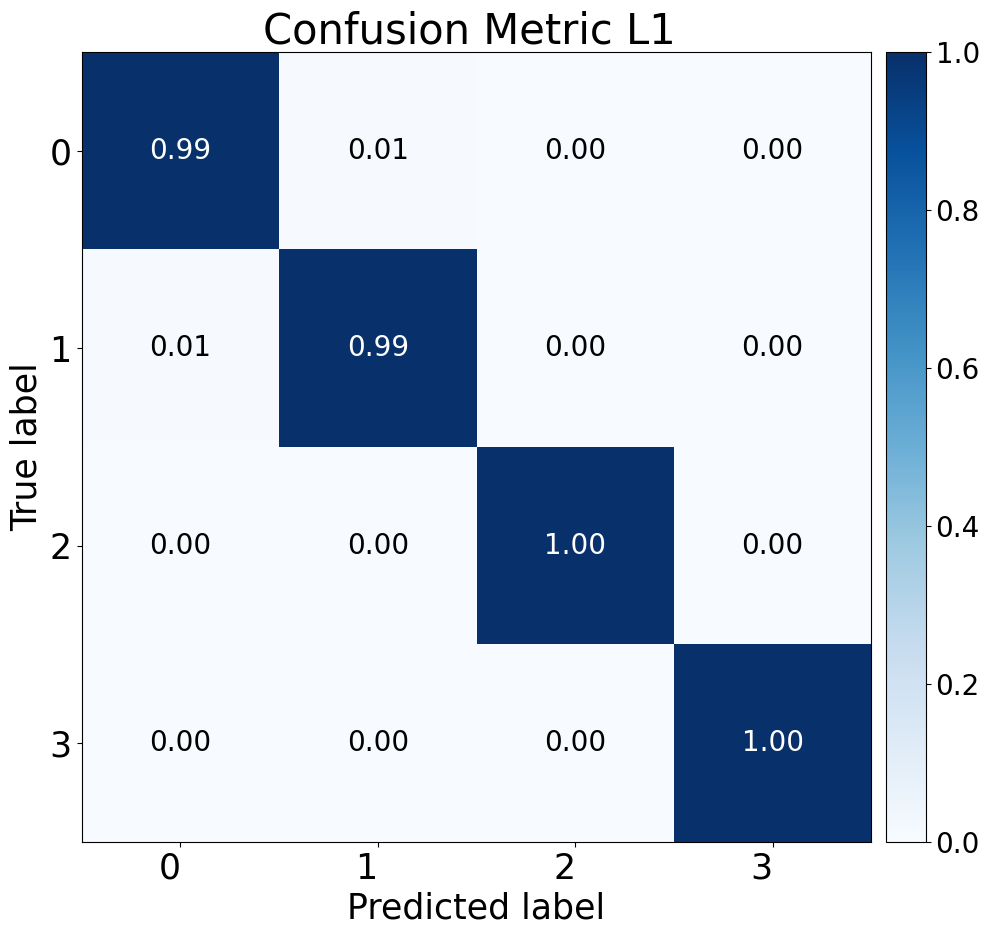

In [88]:
y_pred_l2_rc_int = np.argmax(model_EfficientNetB0L1.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_l2_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric L1 ')

In [89]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_l2_rlr_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_l2_rlr_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9937, Recall = 0.9797, F1 Score = 0.9866
Class 1: Precision = 0.9845, Recall = 0.9953, F1 Score = 0.9899
Class 2: Precision = 0.9953, Recall = 0.9984, F1 Score = 0.9969
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9916
Micro-average Recall: 0.9916
Micro-average F1 Score: 0.9916


In [90]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_l2_rc = model_EfficientNetB0_plateu.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_l2_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 0.9986
Class 1: ROC AUC = 0.9989
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [91]:
data_evaluasi_1={'Model':'EfficientNetB0 With L1 Default','Treatment':'L1','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## Regularization L1 + LR

In [92]:
testeval = model_EfficientNetB0_L1_LR_plateu_Only.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 9s - 145ms/step - accuracy: 0.9856 - loss: 0.3588
Test Loss: 0.3588098883628845
Test Accuracy: 0.9856293201446533


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step
Normalized confusion matrix
[[0.959375  0.0359375 0.003125  0.0015625]
 [0.003125  0.9953125 0.0015625 0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.        1.       ]]


<Axes: title={'center': 'Confusion Metric EfficientNet + L1 + LR '}, xlabel='Predicted label', ylabel='True label'>

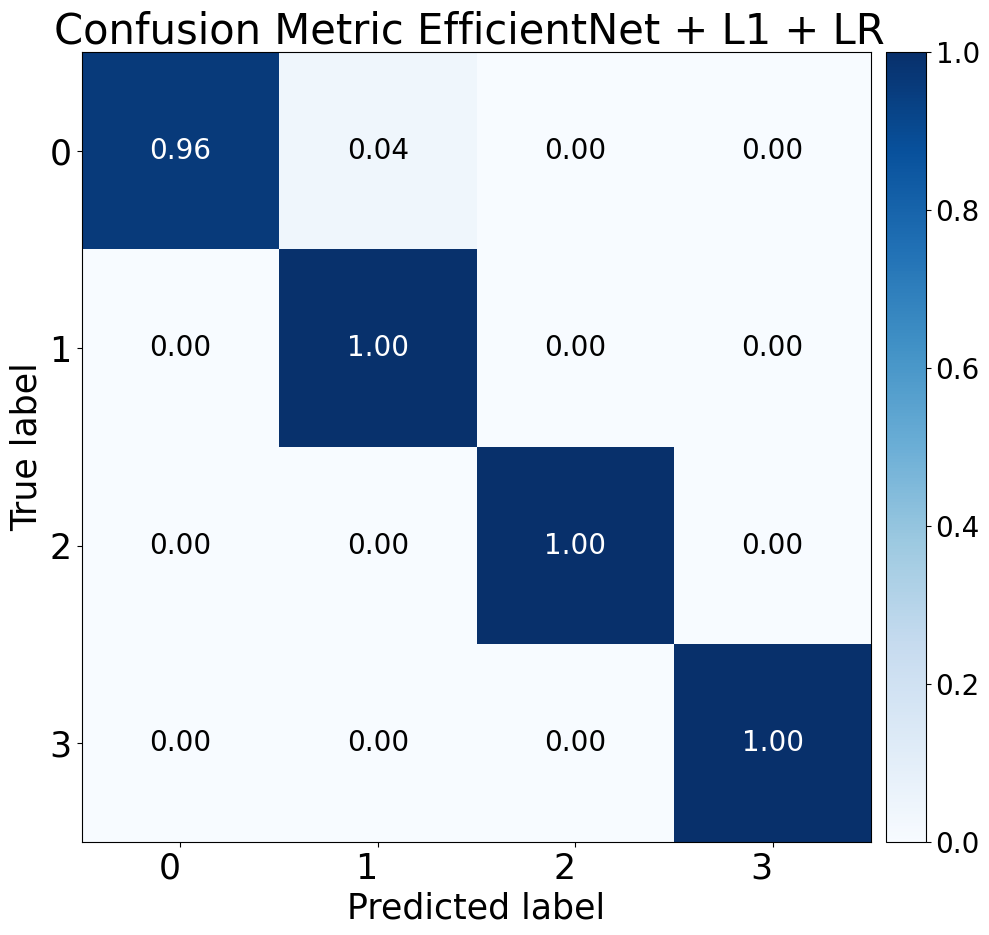

In [93]:
y_pred_l2_rc_int = np.argmax(model_EfficientNetB0_L1_LR_plateu_Only.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_l2_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric EfficientNet + L1 + LR ')

In [94]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_l2_rlr_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_l2_rlr_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9937, Recall = 0.9797, F1 Score = 0.9866
Class 1: Precision = 0.9845, Recall = 0.9953, F1 Score = 0.9899
Class 2: Precision = 0.9953, Recall = 0.9984, F1 Score = 0.9969
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9916
Micro-average Recall: 0.9916
Micro-average F1 Score: 0.9916


In [95]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_l2_rc = model_EfficientNetB0_L1_LR_plateu_Only.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_l2_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 0.9988
Class 1: ROC AUC = 0.9991
Class 2: ROC AUC = 1.0000
Class 3: ROC AUC = 1.0000
Micro-average ROC AUC: 0.9995


In [96]:
data_evaluasi_1={'Model':'EfficientNetB0 With L1 LR','Treatment':'L1 + LR','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

## Regularization L1 + LR + Early Stopping

In [97]:
testeval = model_EfficientNetB0_L1_LR_plateu.evaluate(x_test, y_test, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 9s - 147ms/step - accuracy: 0.3979 - loss: 2.9463
Test Loss: 2.9463164806365967
Test Accuracy: 0.3979187309741974


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step
Normalized confusion matrix
[[0.1234375  0.1203125  0.7453125  0.0109375 ]
 [0.0453125  0.1296875  0.8046875  0.0203125 ]
 [0.0109375  0.0390625  0.946875   0.003125  ]
 [0.25510204 0.10204082 0.28571429 0.35714286]]


<Axes: title={'center': 'Confusion Metric EfficientNet + L1 + LR + ES '}, xlabel='Predicted label', ylabel='True label'>

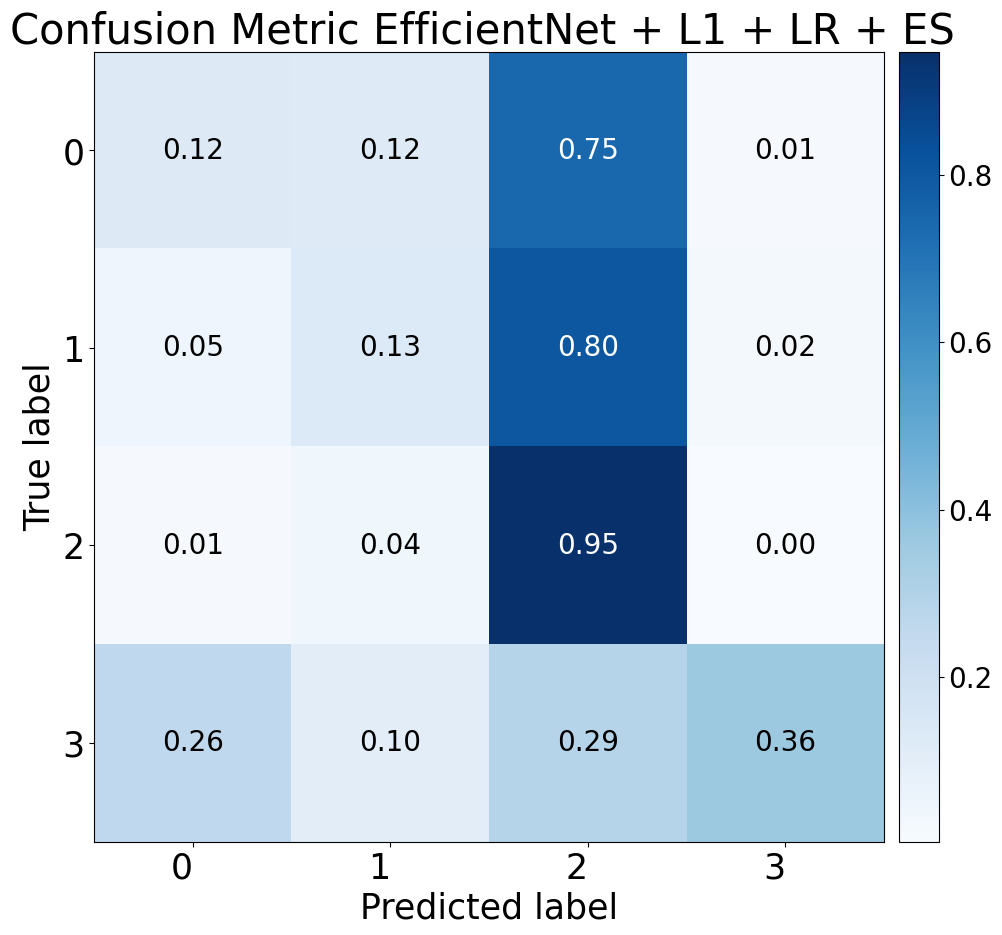

In [98]:
y_pred_l2_rc_int = np.argmax(model_EfficientNetB0_L1_LR_plateu.predict(x_test), axis=1)
class_names = np.unique(y_test_int)
plot_confusion_matrix(y_test_int, y_pred_l2_rc_int, 
                      classes=class_names,
                      normalize=True,
                      title='Confusion Metric EfficientNet + L1 + LR + ES ')

In [99]:
# Predicted integer labels: y_pred_rc_int

# One-hot encode the predicted labels
y_pred_rc = to_categorical(y_pred_l2_rlr_int, num_classes=4)

# True labels one hot encoded: y_test

# True integer labels: y_test_int

# Calculate precision, recall, and F1 score per class (uses integers)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_l2_rlr_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages (uses one hot encoded labels)
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_rc, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

Class 0: Precision = 0.9937, Recall = 0.9797, F1 Score = 0.9866
Class 1: Precision = 0.9845, Recall = 0.9953, F1 Score = 0.9899
Class 2: Precision = 0.9953, Recall = 0.9984, F1 Score = 0.9969
Class 3: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Micro-average Precision: 0.9916
Micro-average Recall: 0.9916
Micro-average F1 Score: 0.9916


In [100]:
# True labels: y_test

# Predicted probability scores for each class
y_probs_l2_rc = model_EfficientNetB0_L1_LR_plateu.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs_l2_rc, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs_rc, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Class 0: ROC AUC = 0.6669
Class 1: ROC AUC = 0.5330
Class 2: ROC AUC = 0.7303
Class 3: ROC AUC = 0.8810
Micro-average ROC AUC: 0.9995


In [101]:
data_evaluasi_1={'Model':'EfficientNetB0 With L1 LR ES','Treatment':'L1 + LR + ES','Akurasi':testeval[1],'F1 Score Micro':round(micro_f1, 4),'ROC AUC Micro':round(roc_auc_micro, 4)}
Gabungan.append(data_evaluasi_1)

In [102]:
import pandas as pd
df = pd.DataFrame(Gabungan)
df.head(20)

,Model,Treatment,Akurasi,F1 Score Micro,ROC AUC Micro
0,EfficientNetB0,default,0.996036,0.9960,1.0000
1,Modified EfficientNetB0,Early Stopping,0.981169,0.9812,0.9995
2,Modified EfficientNetB0,Reduce Learning Rate,0.978692,0.9787,0.9995
3,EfficientNetB0 With L2,L2,0.997522,0.9975,0.9995
4,EfficientNetB0 With L2,L2+ LR + ES,0.978692,0.9787,0.9995
5,EfficientNetB0 With L2,L2+Reduce LR,0.991576,0.9916,0.9995
6,EfficientNetB0 With L1 Default,L1,0.995540,0.9916,0.9995
7,EfficientNetB0 With L1 LR,L1 + LR,0.985629,0.9916,0.9995
8,EfficientNetB0 With L1 LR ES,L1 + LR + ES,0.397919,0.9916,0.9995
